CPH 02/03/2022

# Multiway Online Chromatographic Chemical Analysis (MOCCA) Tutorial

MOCCA is a tool for the analysis of *High-Performance Liquid Chromatography–Diode Array Detection* (HPLC–DAD) datasets which are recorded in the context of reaction (process) controls. It only uses HPLC–DAD raw data and some basic user input which will be explained in this tutorial. For now, the program is only accessible to users with some basic Python skills and a Python environment up and running.

## Installation (pre-publishing)

For the installation of the package, use terminal (or conda cmd.exe) to change directory (cd) into the mocca folder. You can interact with it from the command line after creating (or activating) an isolated development environment (with virtualenv, conda or your preferred tool). To install the package, perform the an editable install:

`pip install -e mocca`

## Imports

In [1]:
# folders handling
import os
from glob import glob

# user interaction
from mocca.user_interaction.campaign import HplcDadCampaign
from mocca.user_interaction.user_objects import Gradient
from mocca.user_interaction.user_objects import Compound
from mocca.user_interaction.user_objects import InternalStandard
from mocca.user_interaction.user_objects import HplcInput
from mocca.user_interaction.settings import Settings

# reporting
from mocca.report.hplc_input import report_hplc_input
from mocca.report.gradient import report_gradients
from mocca.report.chroms import report_chroms
from mocca.report.results import report_runs
from mocca.report.peaks import report_peaks
from mocca.report.quali_comps import report_quali_comps
from mocca.report.quant_comps import report_quant_comps

%load_ext autoreload
%autoreload 2

## Test data folder handling

Some test data are added to the package in order to make this tutorial interactive. The test data can be found in the package in the folder mocca -> notebooks -> test_data. The data was recorded on an Agilent system. For Agilent HPLC–DAD data obtained using the 3D-export macro, the folders containing the DAD*n*.csv files must be given.

In [2]:
# get path of this notebook
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

# add the path to the test data folder
test_data_path = os.path.join(ipynb_path, "tutorial_data")

# find all folders containing Agilent HPLC data (.D file extension)
folders = glob(test_data_path + '/*' + '.D') 
folders = sorted(folders)

We added four paths to the folders variable, which are two gradients (more detail why **two** gradients [below](#gradient_handling)) and two samples containing the same analyte (second only half the concentration). In the following, we want to use the first analyte run to "train" the tool and to subsequently analyze 

In [3]:
for folder in folders:
    print(os.path.basename(folder))

2022-01-26_19-37-57_gradient.D
2022-01-26_19-43-27_gradient.D
2022-01-26_19-48-52_ba_1.D
2022-01-26_20-00-51_ba_0.5.D


## Basic user interaction

The tool uses datasets composed of multiple chromatograms to analyze HPLC–DAD data. These datasets are stored and processed in so called HPLC–DAD campaigns, which later on also contain results of the analysis. You can initialize HplcDadCampaign objects as follows:

In [4]:
camp = HplcDadCampaign()

You can add HPLC–DAD chromatograms to the campaign using HplcInput objects. For any HplcInput object, at least a path to the actual data has to be given as well as a corresponding gradient run.

### Gradient handling <a id='gradient_handling'></a>

Instead of a baseline correction routine for each individual HPLC–DAD chromatogram, mocca requires the data of a pre-recorded gradient run which is baseline-corrected and subsequently subtracted from all following HPLC–DAD chromatograms. A Gradient object in mocca only requires the path to the gradient data.

**Experimental note**: In order to obtain a most representative gradient run for the following data, you should run a "dummy" gradient first and subsequently a second gradient in the fashion, your reaction control takes place. For example, if you run methods of 5 minutes without a pause of 2 minutes in between runs, you should use gradient data which was recorded after the required 5 minutes method and a 2 minutes pause.

In [5]:
# take the second gradient folder
test_gradient = Gradient(folders[1])

At this point, the gradient run is not yet processed. For now, only the path is stored in the object.

### Compound objects: How to train the tool <a id='compound'></a>

You can "train" the tool through Compound objects and analyte HPLC runs. For that, you should have a pure sample of your analyte you want the tool to be trained on. The biggest (by integral) unknown peak in the given data is considered as the given compound by the tool during the data processing.

Compounds **must** contain a key, i.e., a unique identifier as a string and **can** contain a concentration. In the first case, the compound will only be used for peak assignment tasks while adding a concentration leads to the creation of calibration curves and quantification of peaks in reaction runs.

Moreover, the user can give the tool the information if the given compound is a solvent (which will be found in all other chromatograms) or an internal standard (which will be used for retention time correction and relative quantification onwards). This information is required by the tool to process the chromatograms in corresponding order and to function properly.

In [6]:
# solvent component
test_solvent_compound = Compound("solvent_name", is_solvent=True)

# internal standard component
test_istd_compound = Compound("istd_name", is_istd=True)

# compound for peak assignment only
test_compound = Compound("benzaldehyde")

# compound for retention time correction and quantification
test_compound_conc = Compound("benzaldehyde", conc=1)

### Internal standards

The tool can automatically handle internal standards if this information is given by the user. The tool can only handle known internal standards, i.e., internal standards which the tool was already trained on by the [compound method](#compound) (see test_istd_compound). For such internal standards, you can add InternalStandard objects which the tool uses to correct retention times and to quantify relatively to the internal standard signal (only if a internal standard concentration is given).

In [7]:
test_istd_0 = InternalStandard("istd_name")
test_istd_1 = InternalStandard("istd_name", conc=1)

### HPLC input

All above-mentioned user input is bundled into an HplcInput object. This object **must** contain a path to the data and a gradient. It **can** contain a compound and/or an internal standard. HplcInput objects without compound will be analyzed while HplcInput object with compound input are used to train the tool.

For our test data, we create one HplcInput object to train the tool and one HplcObject which will be analyzed.

In [8]:
# training data
init_folder = folders[2]
init_input = HplcInput(init_folder, test_gradient, test_compound_conc)

# test data
analyze_folder = folders[3]
analyze_input =  HplcInput(analyze_folder, test_gradient)

To add these HplcInput objects to the campaign, you can use the add_hplc_input function.

In [9]:
camp.add_hplc_input(init_input)
camp.add_hplc_input(analyze_input)

### Settings for data processing

The campaign has now all the user input required to process the HPLC–DAD data. However, you have control over various processing parameters via the Settings object. The Settings object has some default values which may deliver satisfying results, however, often it is necessary to adjust some values in order to get correct results. The settings parameters are:

**hplc_system_tag**, required: A string indicating which HPLC system was used and from which software the data was exported. So far implemented are "chemstation" for Agilent HPLC systems and "labsolutions" for Shimadzu HPLC systems.

**detector_limit**, optional: A absorbance value which triggers saturation warnings in case it is exceeded in a peak. Default values are 2000 if hplc_system_tag is "chemstation" and 2000 if hplc_system_tag is "labsolutions".

**absorbance_threshold**, optional: A sensitivity measure which defines 1. the summed (over all wavelengths) absorbance value a peak has to exceeed at its maximum to be recognized as a peak, 2. the height of the baseline to which peaks are expanded which is one twentieths of the value. Default value is 500.

**wl_high_pass** and **wl_low_pass**, optional: Constricts the wavelengths which are used for data processing so that for all valid wavelengths wl applies wl_high_pass <= wl <= wl_low_pass. Default value is None for both (no constriction).

**peaks_high_pass** and **peak_low_pass**, optional: Constricts the retention time domain in which peaks are processed so that for all valid peak maxima peak_max applies peaks_high_pass <= peak_max <= peak_low_pass. Default value is None for both (no constriction).

**spectrum_correl_thresh**, optional: Correlation coefficient of two UV-Vis spectra has to exceed this threshold value in order to be a potential match. Default value is 0.95.

**relative_distance_thresh**, optional: The time difference between two peaks (relative to the total chromatogram time) has to be below this threshold value in order to be considered as potential match. Defaul value is 0.01.

In [10]:
settings = Settings('chemstation',
                    absorbance_threshold = 300, wl_high_pass = 215, 
                    peaks_high_pass = 1, peaks_low_pass = 3.2,
                    spectrum_correl_thresh=0.99, relative_distance_thresh=0.01)

### Data processing

You can process the data by adding the above defined settings to the process_all_hplc_input function. Note, that you **must** provide at least a Settings object with an hplc_system_tag given.

-6
11.298775021441125
[[-0.24697033 -0.249523   -0.25207524 -0.25462686 -0.25717776 -0.25972827
  -0.26227874 -0.2648295  -0.26738065 -0.26993231]
 [-0.23881113 -0.24099828 -0.24318504 -0.2453713  -0.24755676 -0.24974122
  -0.25192451 -0.25410645 -0.25628682 -0.25846545]
 [-0.16743196 -0.16994013 -0.17244785 -0.17495485 -0.17746092 -0.17996591
  -0.18246967 -0.18497204 -0.18747284 -0.18997189]]


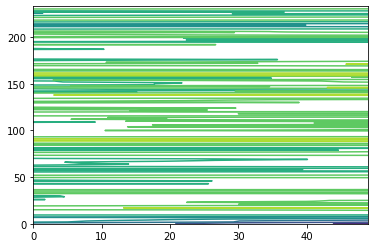

-5
11.309513848301131
[[-0.24441732 -0.24697033 -0.249523   -0.25207524 -0.25462686 -0.25717776
  -0.25972827 -0.26227874 -0.2648295  -0.26738065]
 [-0.23662367 -0.23881113 -0.24099828 -0.24318504 -0.2453713  -0.24755676
  -0.24974122 -0.25192451 -0.25410645 -0.25628682]
 [-0.1649235  -0.16743196 -0.16994013 -0.17244785 -0.17495485 -0.17746092
  -0.17996591 -0.18246967 -0.18497204 -0.18747284]]


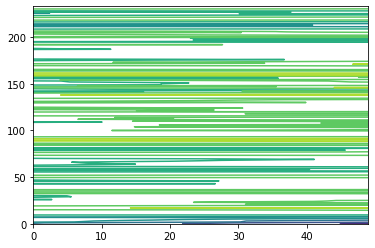

-4
11.320285077975399
[[-0.24186406 -0.24441732 -0.24697033 -0.249523   -0.25207524 -0.25462686
  -0.25717776 -0.25972827 -0.26227874 -0.2648295 ]
 [-0.23443599 -0.23662367 -0.23881113 -0.24099828 -0.24318504 -0.2453713
  -0.24755676 -0.24974122 -0.25192451 -0.25410645]
 [-0.16241487 -0.1649235  -0.16743196 -0.16994013 -0.17244785 -0.17495485
  -0.17746092 -0.17996591 -0.18246967 -0.18497204]]


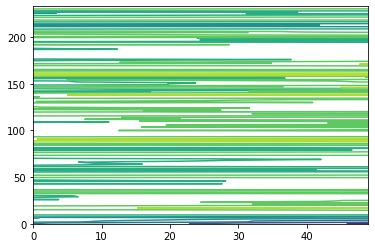

-3
11.331088017655288
[[-0.23931063 -0.24186406 -0.24441732 -0.24697033 -0.249523   -0.25207524
  -0.25462686 -0.25717776 -0.25972827 -0.26227874]
 [-0.23224815 -0.23443599 -0.23662367 -0.23881113 -0.24099828 -0.24318504
  -0.2453713  -0.24755676 -0.24974122 -0.25192451]
 [-0.15990611 -0.16241487 -0.1649235  -0.16743196 -0.16994013 -0.17244785
  -0.17495485 -0.17746092 -0.17996591 -0.18246967]]


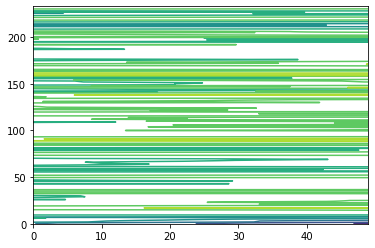

-2
11.341921954516696
[[-0.23675709 -0.23931063 -0.24186406 -0.24441732 -0.24697033 -0.249523
  -0.25207524 -0.25462686 -0.25717776 -0.25972827]
 [-0.23006023 -0.23224815 -0.23443599 -0.23662367 -0.23881113 -0.24099828
  -0.24318504 -0.2453713  -0.24755676 -0.24974122]
 [-0.15739727 -0.15990611 -0.16241487 -0.1649235  -0.16743196 -0.16994013
  -0.17244785 -0.17495485 -0.17746092 -0.17996591]]


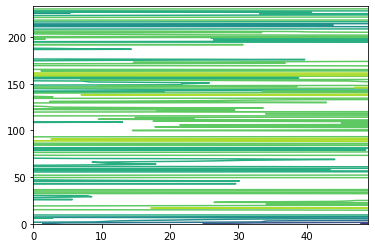

-1
11.352786155645722
[[-0.23420351 -0.23675709 -0.23931063 -0.24186406 -0.24441732 -0.24697033
  -0.249523   -0.25207524 -0.25462686 -0.25717776]
 [-0.22787226 -0.23006023 -0.23224815 -0.23443599 -0.23662367 -0.23881113
  -0.24099828 -0.24318504 -0.2453713  -0.24755676]
 [-0.1548884  -0.15739727 -0.15990611 -0.16241487 -0.1649235  -0.16743196
  -0.16994013 -0.17244785 -0.17495485 -0.17746092]]


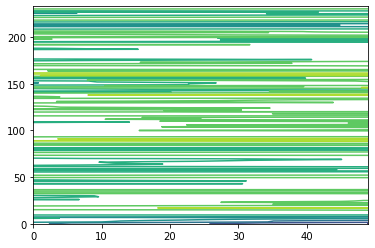

0
11.363679868899183
[[-0.23164991 -0.23420351 -0.23675709 -0.23931063 -0.24186406 -0.24441732
  -0.24697033 -0.249523   -0.25207524 -0.25462686]
 [-0.22568427 -0.22787226 -0.23006023 -0.23224815 -0.23443599 -0.23662367
  -0.23881113 -0.24099828 -0.24318504 -0.2453713 ]
 [-0.15237951 -0.1548884  -0.15739727 -0.15990611 -0.16241487 -0.1649235
  -0.16743196 -0.16994013 -0.17244785 -0.17495485]]


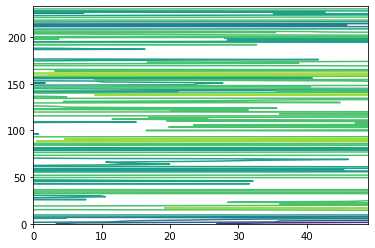

1
11.3746023235689
[[-0.59925818 -0.23164991 -0.23420351 -0.23675709 -0.23931063 -0.24186406
  -0.24441732 -0.24697033 -0.249523   -0.25207524]
 [-0.58390805 -0.22568427 -0.22787226 -0.23006023 -0.23224815 -0.23443599
  -0.23662367 -0.23881113 -0.24099828 -0.24318504]
 [-0.47490641 -0.15237951 -0.1548884  -0.15739727 -0.15990611 -0.16241487
  -0.1649235  -0.16743196 -0.16994013 -0.17244785]]


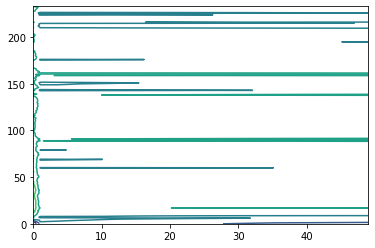

2
11.385552731106479
[[-0.59925818 -0.6003828  -0.23164991 -0.23420351 -0.23675709 -0.23931063
  -0.24186406 -0.24441732 -0.24697033 -0.249523  ]
 [-0.58390805 -0.58503391 -0.22568427 -0.22787226 -0.23006023 -0.23224815
  -0.23443599 -0.23662367 -0.23881113 -0.24099828]
 [-0.47490641 -0.47651089 -0.15237951 -0.1548884  -0.15739727 -0.15990611
  -0.16241487 -0.1649235  -0.16743196 -0.16994013]]


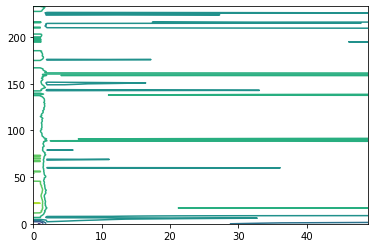

3
11.39653028596085
[[-0.59925818 -0.6003828  -0.6013743  -0.23164991 -0.23420351 -0.23675709
  -0.23931063 -0.24186406 -0.24441732 -0.24697033]
 [-0.58390805 -0.58503391 -0.58604725 -0.22568427 -0.22787226 -0.23006023
  -0.23224815 -0.23443599 -0.23662367 -0.23881113]
 [-0.47490641 -0.47651089 -0.47800098 -0.15237951 -0.1548884  -0.15739727
  -0.15990611 -0.16241487 -0.1649235  -0.16743196]]


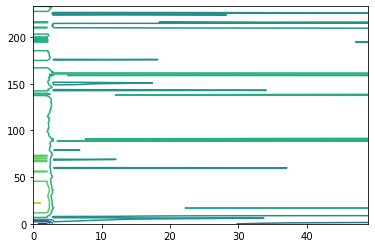

4
11.407534166177504
[[-0.59925818 -0.6003828  -0.6013743  -0.60223579 -0.23164991 -0.23420351
  -0.23675709 -0.23931063 -0.24186406 -0.24441732]
 [-0.58390805 -0.58503391 -0.58604725 -0.58695035 -0.22568427 -0.22787226
  -0.23006023 -0.23224815 -0.23443599 -0.23662367]
 [-0.47490641 -0.47651089 -0.47800098 -0.4793783  -0.15237951 -0.1548884
  -0.15739727 -0.15990611 -0.16241487 -0.1649235 ]]


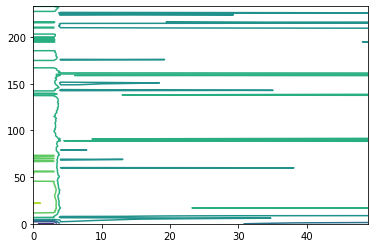

5
11.418563534188511
[[-0.59925818 -0.6003828  -0.6013743  -0.60223579 -0.60297038 -0.23164991
  -0.23420351 -0.23675709 -0.23931063 -0.24186406]
 [-0.58390805 -0.58503391 -0.58604725 -0.58695035 -0.58774548 -0.22568427
  -0.22787226 -0.23006023 -0.23224815 -0.23443599]
 [-0.47490641 -0.47651089 -0.47800098 -0.4793783  -0.48064446 -0.15237951
  -0.1548884  -0.15739727 -0.15990611 -0.16241487]]


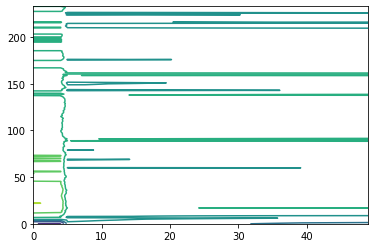

6
11.429617537669552
[[-0.59925818 -0.6003828  -0.6013743  -0.60223579 -0.60297038 -0.60358114
  -0.23164991 -0.23420351 -0.23675709 -0.23931063]
 [-0.58390805 -0.58503391 -0.58604725 -0.58695035 -0.58774548 -0.58843493
  -0.22568427 -0.22787226 -0.23006023 -0.23224815]
 [-0.47490641 -0.47651089 -0.47800098 -0.4793783  -0.48064446 -0.48180107
  -0.15237951 -0.1548884  -0.15739727 -0.15990611]]


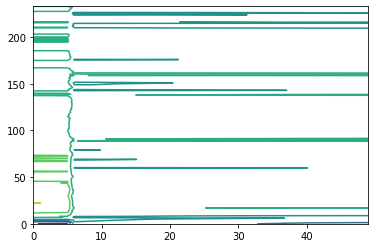

ValueError: operands could not be broadcast together with shapes (234,2494) (234,2489) 

In [18]:
camp.process_all_hplc_input(settings)

## Result extraction and reporting

The reporting will be refined on the fly during alpha and beta version rollout. For now, each report has to be created separately. When we have decided on the final reporting design, there will be a report_all function on the campaign. During this tutorial, we store all reports in the test_reports folder.

In [ ]:
test_report_path = os.path.join(ipynb_path, "tutorial_reports")

In the following sections, all relevant data are presented first in the Pythonic form, i.e., in which object the information is stored. Then, the corresponding report will be created.

### User input

Let's first look at the stored user input and the corresponding report.

In [ ]:
# where to find in environment
print(camp.hplc_runs)

In [ ]:
# create report
report_hplc_input(camp.hplc_runs, test_report_path)

### Gradients

Gradient objects can be found as attributes in the above mentioned HplcInput objects. We can have a look at all gradients used in the campaign using the reporting function.

In [ ]:
# create report
report_gradients(camp.hplc_runs, test_report_path)

### Chromatograms

This is the main results source which you find in the chroms attribute of the campaign. The chromatograms have several attributes like experiment (the HPLC input), peaks (all picked and processed peaks of the chromatogram), dataset (the HPLC–DAD raw data object) and a boolean value in bad_data which indicates if the analysis has found some critical problem with the dataset (e.g. the user gives an internal standard but the corrsponding peak was not found).

In [ ]:
# where to find in environment
print(f"Chroms attribute:\n{camp.chroms}\n")
print(f"User input for the chrom:\n{camp.chroms[0].experiment}\n")  # hplc_input is labelled "experiment" in the backend
print(f"Found peaks:\n{camp.chroms[0].peaks}\n")
print(f"Dataset:\n{camp.chroms[0].dataset}\n")
print(f"Bad Data:\n{camp.chroms[0].bad_data}")

With this approach, you can also follow integrals and/or concentrations of compounds over multiple chromatograms. For that, an extra report can be created.

In [ ]:
report_chroms(camp.chroms, camp.settings, test_report_path)
report_runs(camp.chroms, camp.quali_comp_db, camp.quant_comp_db, test_report_path)

### Peak database

In this attribute, all processed peaks of all chromatograms in the campaign are stored. This database is used to create the qualitative and the quantitative component databases.

In [ ]:
print(f"Database object:\n{camp.peak_db}\n")

print("Database entries (peaks):")
for peak in camp.peak_db:
    print(peak)

In [ ]:
report_peaks(camp.peak_db, test_report_path)

### Qualitative component database

In this database, the components (created from the signals of the same compound over multiple chromatograms) contain the information needed for peak assignment.

In [ ]:
print(f"Database object:\n{camp.quali_comp_db}\n")

print("Database entries (qualitative components):")
for comp in camp.quali_comp_db:
    print(comp)

In [ ]:
report_quali_comps(camp.quali_comp_db, test_report_path)

### Quantitative component database

In this database, the components (created from the signals of the same compound over multiple chromatograms) contain the information needed for peak quantification.

In [ ]:
print(f"Database object:\n{camp.quant_comp_db}\n")

print("Database entries (quantitative components):")
for comp in camp.quant_comp_db:
    print(comp)

In [ ]:
report_quant_comps(camp.quant_comp_db, test_report_path)